In [2]:
import omicverse as ov
import scanpy as sc
import scvelo as scv

ov.utils.ov_plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.8, Tutorials: https://omicverse.readthedocs.io/
Dependency error: (pygam 0.9.1 (/home/lsg/anaconda3/envs/ScAnnotation/lib/python3.10/site-packages), Requirement.parse('pygam==0.8.0'))


In [3]:
adata = ov.read('/home/lsg/Data/glioblastoma/kang.h5ad')
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [4]:
#quantity control
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250},doublets_method='sccomposite',)
#normalize and high variable genes (HVGs) calculated
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)

#save the whole genes and filter the non-HVGs
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]

#scale the adata.X
ov.pp.scale(adata)

#Dimensionality Reduction
ov.pp.pca(adata,layer='scaled',n_pcs=50)

adata.obsm['X_mde']=ov.utils.mde(adata.obsm['scaled|original|X_pca'])

CPU mode activated
Calculate QC metrics
End calculation of QC metrics.
Original cell number: 24673
!!!It should be noted that the `sccomposite` will remove more cells than             `scrublet`!!!
Begin of post doublets removal and QC plot using `sccomposite`
Cuda is not available; Fitting the COMPOSITE model on RNA modality
The RNA modality goodness-of-fit score is: 4.017655424230639 
<3: poor fit 
3~5: moderate fit 
>5: good fit
Cells retained after sccomposite: 23432, 1241 removed.
End of post sccomposite removal and QC plots.
Filters application (seurat or mads)
Lower treshold, nUMIs: 500; filtered-out-cells:         0
Lower treshold, n genes: 250; filtered-out-cells:         142
Lower treshold, mito %: 0.2; filtered-out-cells:         0
Filters applicated.
Total cell filtered out with this last --mode seurat QC (and its     chosen options): 142
Cells retained after scrublet and seurat filtering: 23290, 1383 removed.
filtered out 276 genes that are detected in less than 3 cells
Be

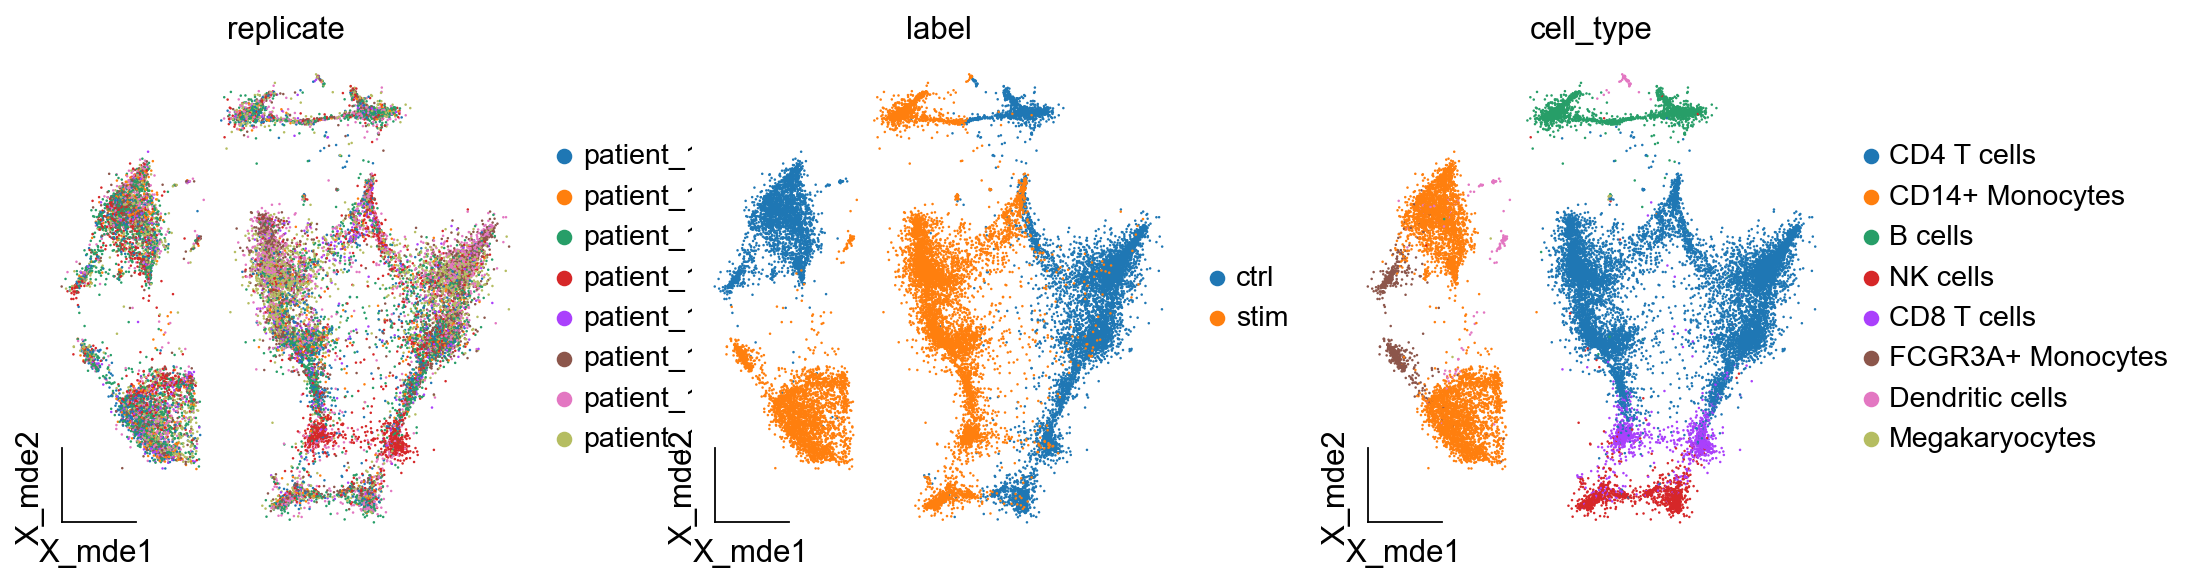

In [5]:
ov.utils.embedding(adata,
                   basis='X_mde',
                    frameon='small',
                   color=['replicate','label','cell_type'])

In [6]:
adata_harmony=ov.single.batch_correction(adata,batch_key='replicate',methods='harmony',n_pcs=50)
adata


...Begin using harmony to correct batch effect


2024-12-11 22:54:35,073 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-11 22:54:44,564 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-11 22:54:44,699 - harmonypy - INFO - Iteration 1 of 10
2024-12-11 22:54:53,205 - harmonypy - INFO - Iteration 2 of 10
2024-12-11 22:55:02,297 - harmonypy - INFO - Iteration 3 of 10
2024-12-11 22:55:10,589 - harmonypy - INFO - Converged after 3 iterations


AnnData object with n_obs × n_vars = 23290 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'sccomposite_doublet', 'sccomposite_consistency', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'name', 'mt', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg', 'pca', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'replicate_colors', 'label_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'scaled|original|X_pca', 'X_mde', 'X_harmony'
    varm: 'PCs', 'scaled|original|pca_loadings'
    layers: 'counts', 'scaled', 'lognorm'

In [8]:
adata.obsm["X_mde_harmony"] = ov.utils.mde(adata.obsm["X_harmony"])

[<AxesSubplot: title={'center': 'replicate'}, xlabel='X_mde_harmony1', ylabel='X_mde_harmony2'>,
 <AxesSubplot: title={'center': 'label'}, xlabel='X_mde_harmony1', ylabel='X_mde_harmony2'>,
 <AxesSubplot: title={'center': 'cell_type'}, xlabel='X_mde_harmony1', ylabel='X_mde_harmony2'>]

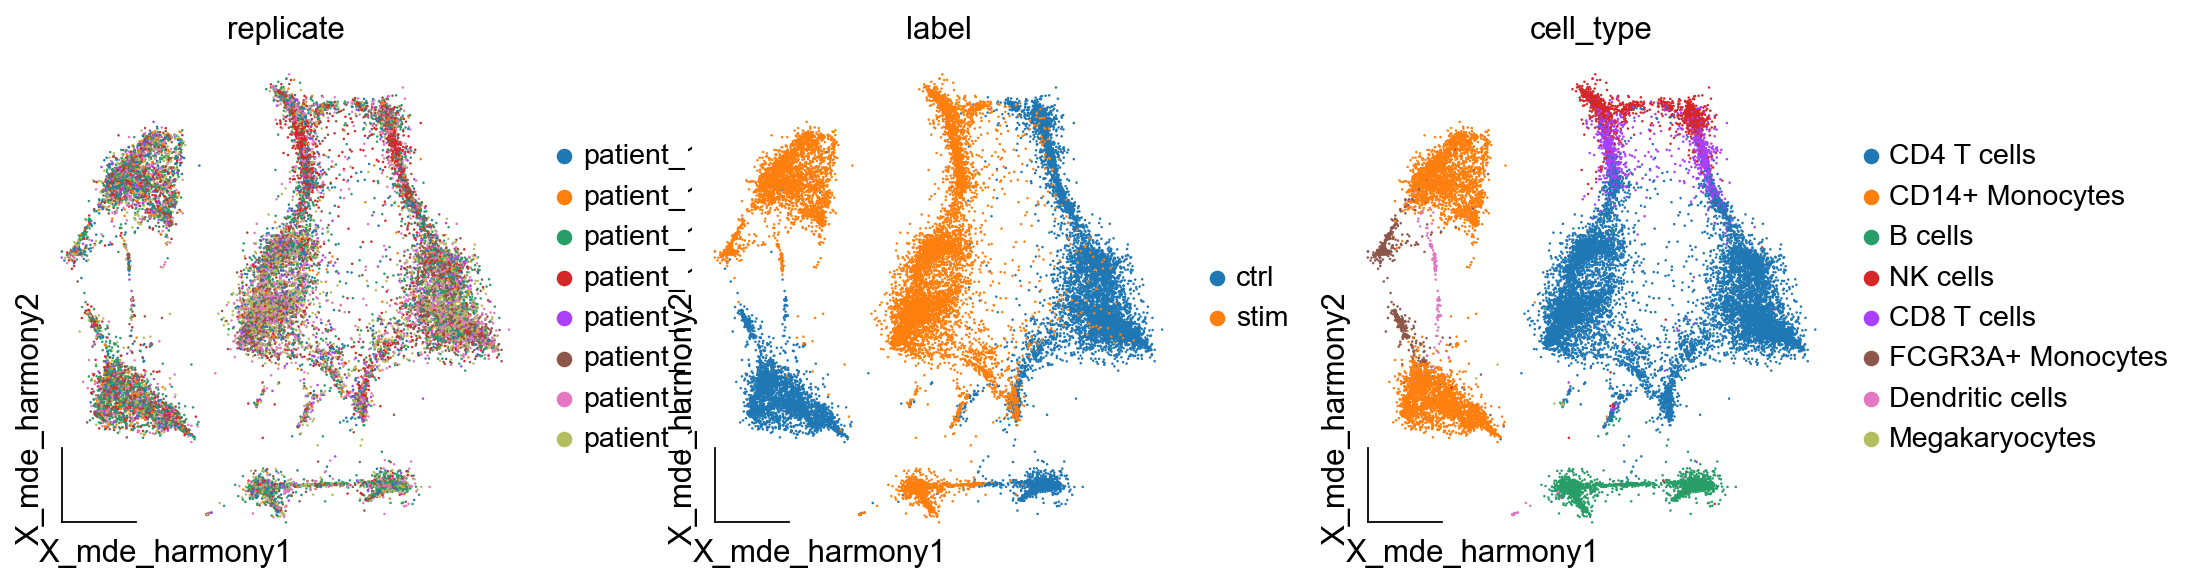

In [9]:
ov.utils.embedding(adata,
                basis='X_mde_harmony',frameon='small',
                color=['replicate','label','cell_type'],show=False)

In [10]:
test_adata=adata[adata.obs['cell_type'].isin(['CD4 T cells'])]
dds=ov.bulk.pyDEG(test_adata.to_df(layer='lognorm').T)
dds.drop_duplicates_index()
print('... drop_duplicates_index success')

... drop_duplicates_index success


In [11]:
treatment_groups=test_adata.obs[test_adata.obs['label']=='stim'].index.tolist()
control_groups=test_adata.obs[test_adata.obs['label']=='ctrl'].index.tolist()
dds.deg_analysis(treatment_groups,control_groups,method='ttest')

,pvalue,qvalue,FoldChange,MaxBaseMean,BaseMean,log2(BaseMean),log2FC,abs(log2FC),size,-log(pvalue),-log(qvalue),sig
index,,,,,,,,,,,,
MALAT1,9.642008e-01,0.983377,1.000033,10.630383,10.630209,3.410098,0.000047,0.000047,0.100003,0.015833,0.007280,normal
B2M,0.000000e+00,0.000000,1.042660,10.026056,9.820938,3.295861,0.060269,0.060269,0.104266,inf,inf,sig
TMSB4X,1.180710e-06,0.000007,1.005455,9.791958,9.765394,3.287678,0.007848,0.007848,0.100545,5.927857,5.183129,sig
FTH1,0.000000e+00,0.000000,0.913172,9.135904,8.739258,3.127511,-0.131041,0.131041,0.091317,inf,inf,sig
RPL13,1.743566e-07,0.000001,0.986825,8.641390,8.584460,3.101727,-0.019134,0.019134,0.098682,6.758562,5.983871,sig
...,...,...,...,...,...,...,...,...,...,...,...,...
CCL23,3.193360e-01,0.484396,3.149497,0.001057,0.000528,-10.886377,1.655121,1.655121,0.314950,0.495752,0.314800,normal
FCRLA,3.193361e-01,0.484396,3.111923,0.001038,0.000519,-10.911819,1.637806,1.637806,0.311192,0.495752,0.314800,normal
SERPINA9,3.153542e-01,0.484396,0.327066,0.001011,0.000506,-10.949496,-1.612344,1.612344,0.032707,0.501201,0.314800,normal


In [12]:
# -1 means automatically calculates
dds.foldchange_set(fc_threshold=-1,
                   pval_threshold=0.05,
                   logp_max=10)

... Fold change threshold: 0.8972858786582947


<AxesSubplot: title={'center': 'DEG Analysis'}, xlabel='$log_{2}FC$', ylabel='$-log_{10}(qvalue)$'>

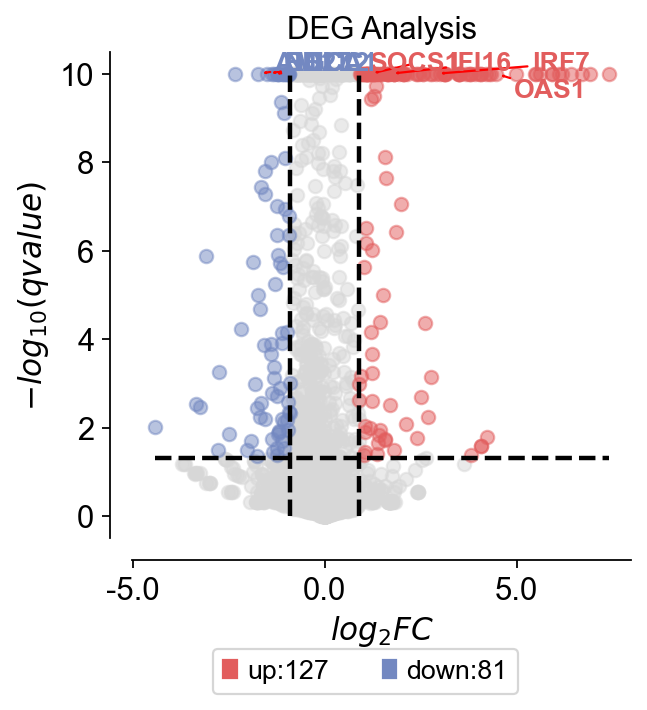

In [13]:
dds.plot_volcano(title='DEG Analysis',figsize=(4,4),
                 plot_genes_num=8,plot_genes_fontsize=12,)

(<Figure size 160x240 with 1 Axes>,
 <AxesSubplot: title={'center': 'Gene Expression'}>)

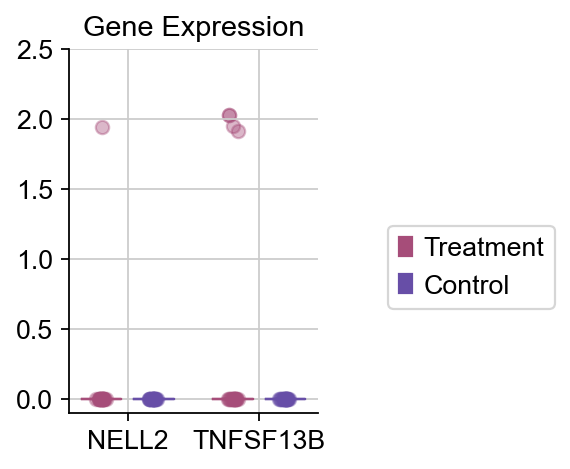

In [14]:
dds.plot_boxplot(genes=['NELL2','TNFSF13B'],treatment_groups=treatment_groups,
                control_groups=control_groups,figsize=(2,3),fontsize=12,
                 legend_bbox=(2,0.55))

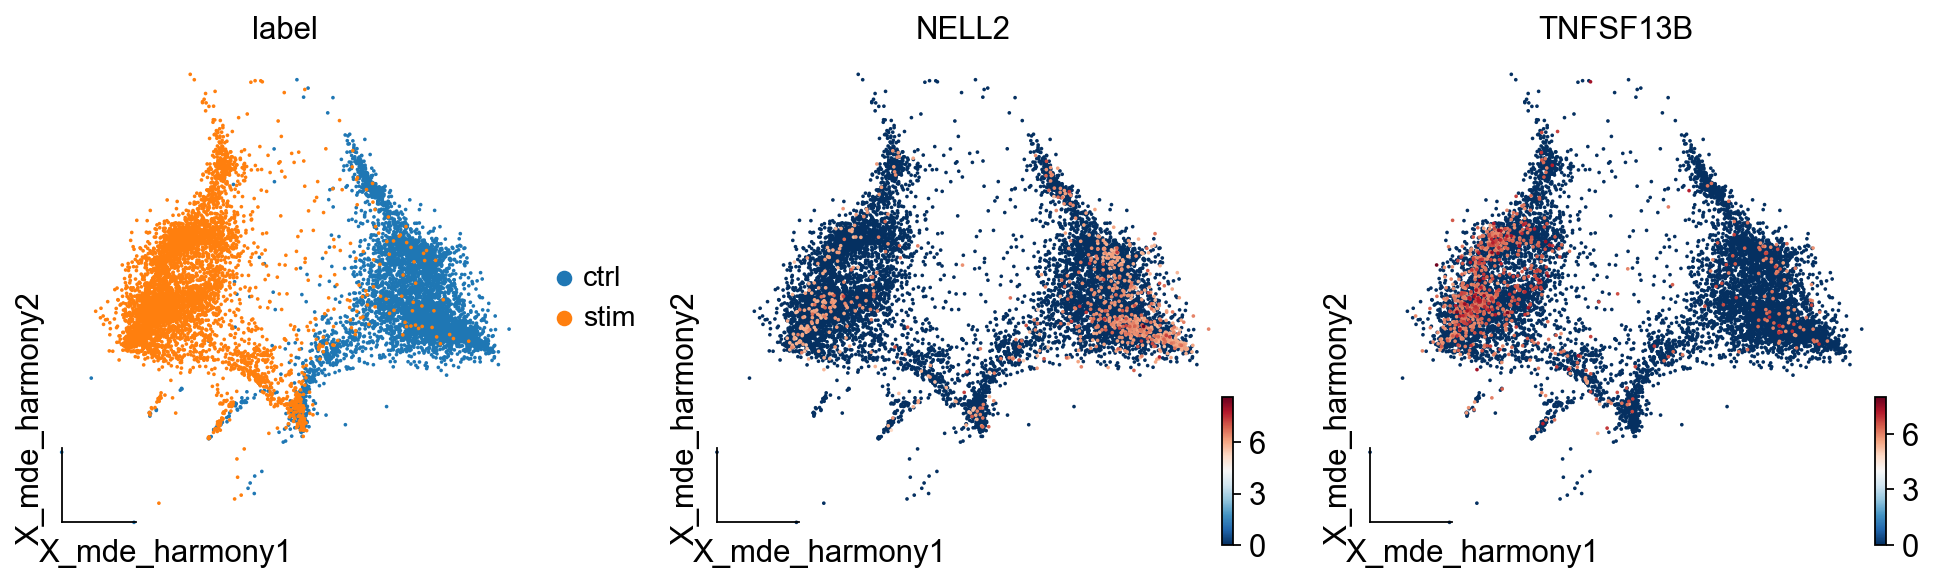

In [15]:
ov.utils.embedding(test_adata,
                   basis='X_mde_harmony',
                    frameon='small',
                   color=['label','NELL2','TNFSF13B'])

In [16]:
test_adata=adata[adata.obs['cell_type'].isin(['CD4 T cells'])]
dds=ov.bulk.pyDEG(test_adata.to_df(layer='counts').T)
dds.drop_duplicates_index()
print('... drop_duplicates_index success')

treatment_groups=test_adata.obs[test_adata.obs['label']=='stim'].index.tolist()
control_groups=test_adata.obs[test_adata.obs['label']=='ctrl'].index.tolist()
dds.deg_analysis(treatment_groups,control_groups,method='DEseq2')

... drop_duplicates_index success


Fitting size factors...
... done in 0.30 seconds.

Fitting dispersions...
... done in 3.06 seconds.

Fitting dispersion trend curve...
... done in 0.59 seconds.

Fitting MAP dispersions...
/home/lsg/anaconda3/envs/ScAnnotation/lib/python3.10/site-packages/pydeseq2/utils.py:611: RuntimeWarning: invalid value encountered in log
  log_alpha_hat = np.log(alpha_hat)
/home/lsg/anaconda3/envs/ScAnnotation/lib/python3.10/site-packages/pydeseq2/utils.py:652: RuntimeWarning: invalid value encountered in log
  x0=np.log(alpha_hat),
/home/lsg/anaconda3/envs/ScAnnotation/lib/python3.10/site-packages/numpy/linalg/linalg.py:2120: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/home/lsg/anaconda3/envs/ScAnnotation/lib/python3.10/site-packages/pydeseq2/utils.py:611: RuntimeWarning: invalid value encountered in log
  log_alpha_hat = np.log(alpha_hat)
/home/lsg/anaconda3/envs/ScAnnotation/lib/python3.10/site-packages/pydeseq2/utils.py:6

logres_prior=nan, sigma_prior=nan


... done in 39.60 seconds.

Fitting LFCs...
... done in 321.71 seconds.

Refitting 5 outliers.

Fitting dispersions...
... done in 0.05 seconds.

Fitting MAP dispersions...
/home/lsg/anaconda3/envs/ScAnnotation/lib/python3.10/site-packages/numpy/linalg/linalg.py:2120: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/home/lsg/anaconda3/envs/ScAnnotation/lib/python3.10/site-packages/numpy/linalg/linalg.py:2120: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/home/lsg/anaconda3/envs/ScAnnotation/lib/python3.10/site-packages/numpy/linalg/linalg.py:2120: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
... done in 0.27 seconds.

Fitting LFCs...
... done in 0.84 seconds.

Running Wald tests...
... done in 53.19 seconds.

Log2 fold change & Wald test p-value: condition Treatment vs Control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
index,,,,,,
MALAT1,99.107032,-6.073760e-01,0.012789,-4.749374e+01,0.0,0.0
B2M,37.870913,2.941553e-11,0.004351,6.759884e-09,1.0,1.0
TMSB4X,41.337899,-5.398822e-01,0.012527,-4.309687e+01,0.0,0.0
FTH1,31.075771,-1.254140e+00,0.030075,-4.170006e+01,0.0,0.0
RPL13,15.253015,-7.791013e-01,0.016054,-4.852931e+01,0.0,0.0
...,...,...,...,...,...,...
KCNG1,0.000000,NaN,NaN,NaN,NaN,NaN
CLEC4C,0.000000,NaN,NaN,NaN,NaN,NaN
APBB2,0.000000,NaN,NaN,NaN,NaN,NaN


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,qvalue,-log(pvalue),-log(qvalue),BaseMean,log2(BaseMean),log2FC,abs(log2FC),sig
index,,,,,,,,,,,,,,
MALAT1,99.107032,-6.073760e-01,0.012789,-4.749374e+01,0.0,0.0,0.0,inf,inf,99.107032,6.645400,-6.073760e-01,6.073760e-01,sig
B2M,37.870913,2.941553e-11,0.004351,6.759884e-09,1.0,1.0,1.0,2.342414e-09,2.342414e-09,37.870913,5.280619,2.941553e-11,2.941553e-11,normal
TMSB4X,41.337899,-5.398822e-01,0.012527,-4.309687e+01,0.0,0.0,0.0,inf,inf,41.337899,5.403878,-5.398822e-01,5.398822e-01,sig
FTH1,31.075771,-1.254140e+00,0.030075,-4.170006e+01,0.0,0.0,0.0,inf,inf,31.075771,5.003412,-1.254140e+00,1.254140e+00,sig
RPL13,15.253015,-7.791013e-01,0.016054,-4.852931e+01,0.0,0.0,0.0,inf,inf,15.253015,4.022635,-7.791013e-01,7.791013e-01,sig
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KCNG1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,normal
CLEC4C,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,normal
APBB2,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,normal


In [17]:
# -1 means automatically calculates
dds.foldchange_set(fc_threshold=1.2,
                   pval_threshold=0.05,
                   logp_max=10)

... Fold change threshold: 1.2


<AxesSubplot: title={'center': 'DEG Analysis'}, xlabel='$log_{2}FC$', ylabel='$-log_{10}(qvalue)$'>

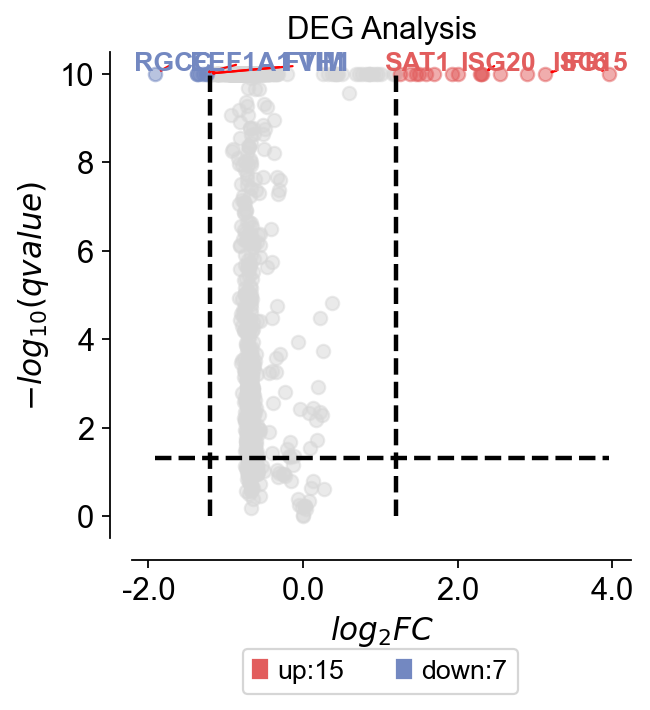

In [18]:
dds.plot_volcano(title='DEG Analysis',figsize=(4,4),
                 plot_genes_num=8,plot_genes_fontsize=12,)

(<Figure size 160x240 with 1 Axes>,
 <AxesSubplot: title={'center': 'Gene Expression'}>)

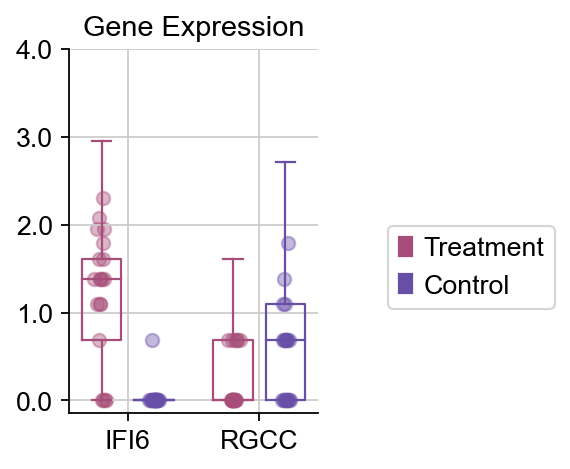

In [19]:
dds.plot_boxplot(genes=['IFI6','RGCC'],treatment_groups=treatment_groups,
                control_groups=control_groups,figsize=(2,3),fontsize=12,
                 legend_bbox=(2,0.55))

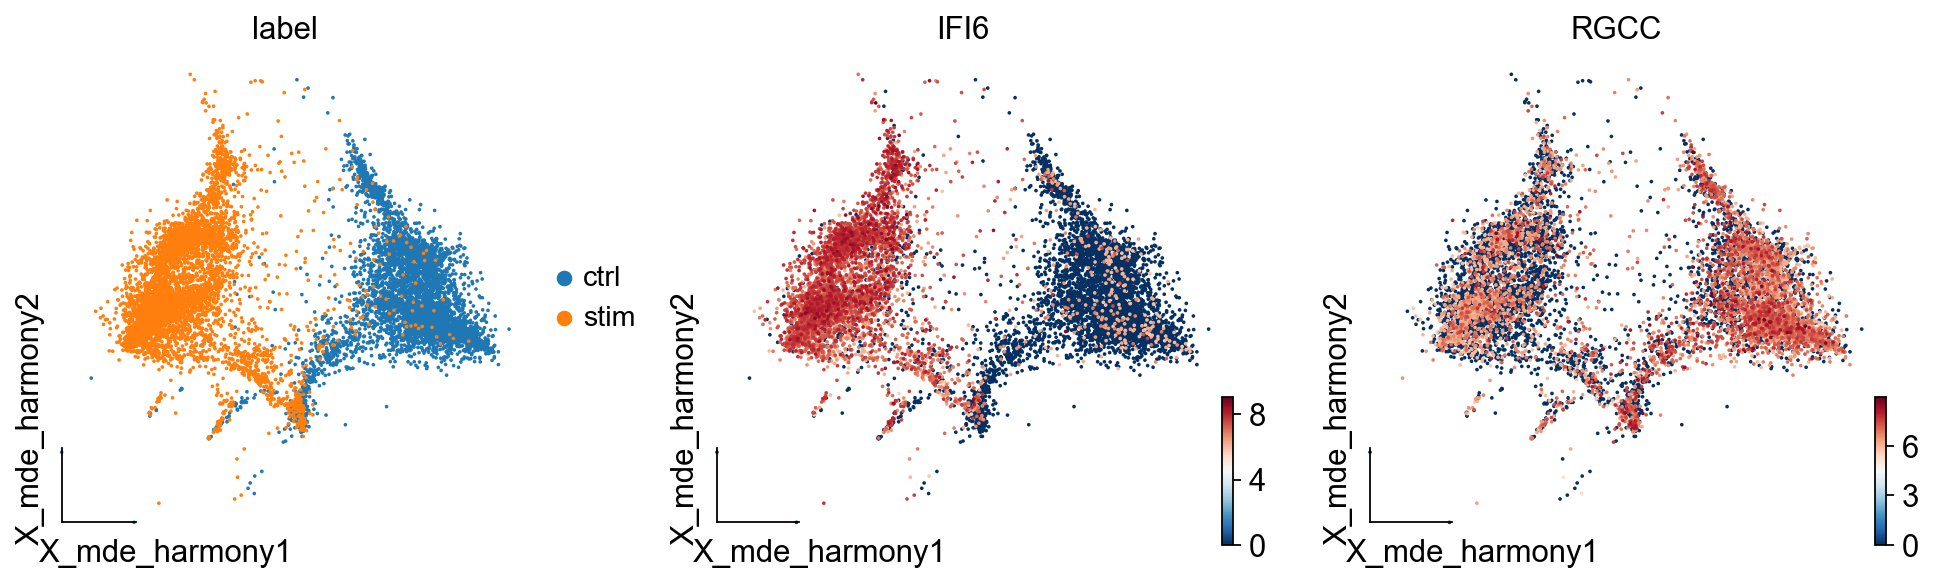

In [21]:
ov.utils.embedding(test_adata,
                   basis='X_mde_harmony',
                    frameon='small',
                   color=['label','IFI6','RGCC'])

In [22]:
meta_obj=ov.single.MetaCell(adata,use_rep='X_harmony',n_metacells=250,
                           use_gpu=True)

Welcome to SEACells GPU!


In [23]:
meta_obj.initialize_archetypes()

Computing kNN graph using scanpy NN ...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/23290 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/23290 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/23290 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_harmony
Computing diffusion components from X_harmony for waypoint initialization ... 
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
Done.
Sampling waypoints ...
Done.
Selecting 232 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 28/28 [00:01<00:00, 15.10it/s]

Selecting 18 cells from greedy initialization.
